## CSCA 5642 Week 3 Project - Binary Classification of Histopathology Data

#### The histopathology dataset downloaded from Kaggle (https://www.kaggle.com/competitions/histopathologic-cancer-detection/data) includes images of pathology scans for tumor cells. The purpose of this program will be to identify which histopathology scans contain tumor growth.

##### The training dataset contains a large number of images for training, along with a csv file containing training labels. 

In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2

## EDA and Data Cleaning
#### Data is downloaded from the Kaggle API. Images are in .tif format which is incompatible with Keras, so the first step after importing the data will be to convert them to .png format.

In [16]:
train_path = 'train/'

output_path = 'converted_dataset/'

In [17]:
for filename in os.listdir(train_path):
    filepath = os.path.join(train_path, filename)
    output_file = os.path.join(output_path, os.path.splitext(filename)[0] + ".png")
    img = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
    cv2.imwrite(output_file, img)

#### The next step before importing to Keras is to split the images into folders based on their respective classes. This will allow for labels to be attached to images upon import to Keras, so the labels will be attached to the images.

In [24]:
import shutil
train_path = 'converted_dataset/'
train_labels = pd.read_csv('train_labels.csv')
print(train_labels.head())
print(os.listdir(train_path)[:10])

class_0_dir = os.path.join(train_path, 'class_0')
class_1_dir = os.path.join(train_path, 'class_1')

os.makedirs(class_0_dir, exist_ok=True)
os.makedirs(class_1_dir, exist_ok=True)

for i,row in train_labels.iterrows():
  filename = row['id'] + '.png'
  src_path = os.path.join(train_path,filename)
  if os.path.exists(src_path):
    if row['label'] == 0:
      shutil.move(src_path, class_0_dir)
    else:
      shutil.move(src_path, class_1_dir)

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
['5f00fd4a51664ae9baa4797497ba3ba51f330197.png', '07153a1b0bee5d997ef00bab1bf0eaeabfca110b.png', '4e7f0c6470172c7783d7e3017d81c933b22396b9.png', 'c75f123b8a0ce5bf05a7b46f594daabc73923e57.png', 'dbedac5308b18f64f88153d9bc431df1bab1907c.png', '835a8179f5936e0cf67e471d1bc3200240c5d49b.png', '80b7f2943f73962f4cfc02ea6b15a57e12d1393f.png', '4bbd0dc5d21f86db3682c7ed7d432c6ea766badb.png', '8526c487fa9fd0f85128e53f83bf4ed35bd1c343.png', '0f9f21b84999b2c4573b253b1b45449facb79d0e.png']


#### It would be good to know the size of the images for our model training, since we are specifically trying to understand the inner 32x32 pixel space. We also will need this information for the keras import.

In [26]:
#Find size of images:

image_path = 'converted_dataset/class_0/f38a6374c348f90b587e046aac6079959adf3835.png'
img = Image.open(image_path)
width, height = img.size

print('Image sizes:', width, 'x', height)

Image sizes: 96 x 96


In [158]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(width,height),
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=123
)

Found 220025 files belonging to 2 classes.
Using 176020 files for training.


#### Next, we will look at a few images to understand what the data looks like and what we are looking for. This will also help us visually inspect differences between the classes.

2025-02-14 15:56:59.790983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [176020]
	 [[{{node Placeholder/_4}}]]
2025-02-14 15:56:59.791420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [176020]
	 [[{{node Placeholder/_4}}]]


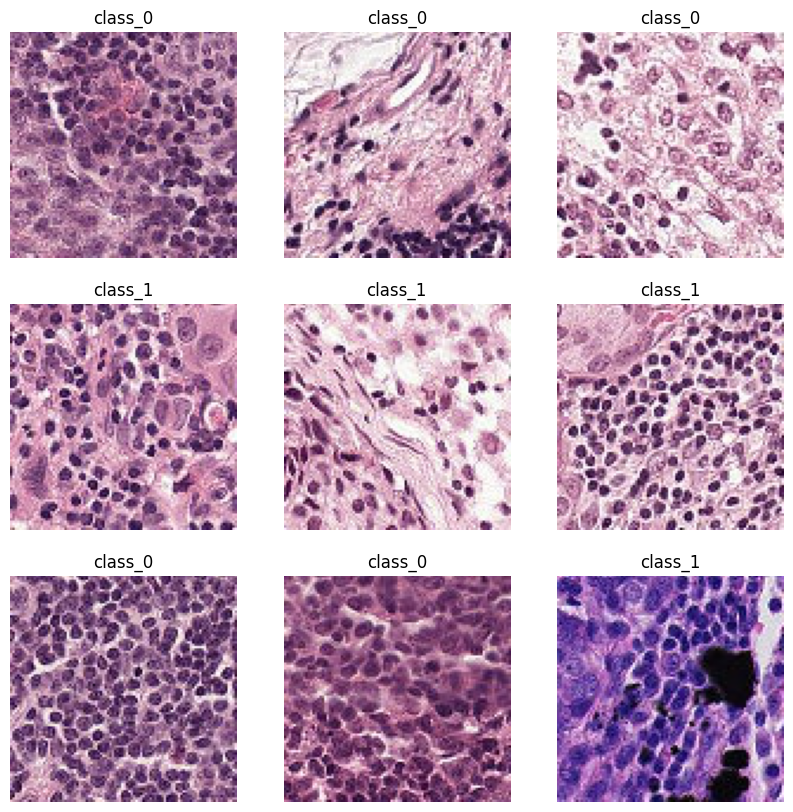

In [28]:
classes = train_dataset.class_names

for images, labels in train_dataset.take(1):  # Take one batch
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i].numpy()])
        plt.axis("off")
    break

#### We will look at a bar chart to understand how many results are positive vs negative.

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
[130908, 89117]


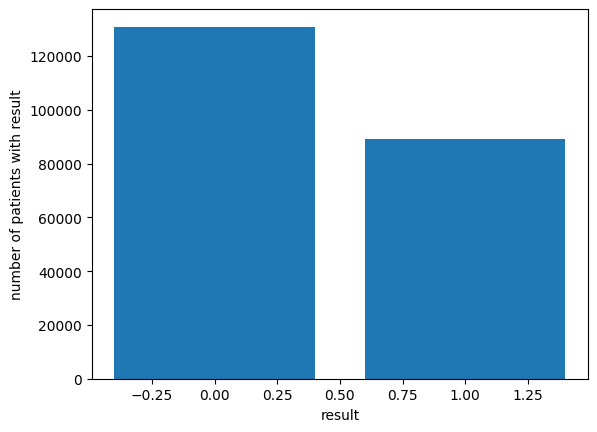

In [51]:
vals = train_labels['label'].value_counts().tolist()
print(vals)
plt.bar([0,1],vals)
plt.xlabel('result')
plt.ylabel('number of patients with result')
plt.show()

## Designing Model Architecture

#### I'll use a simple (conv-conv-maxpool)n architecture. This is a common architecture used in this type of image analysis, so seems like a good place to start. I will use ReLU in the Conv layers, then a sigmoid activation function in the output layer. I'll use this base function to modify the optimizer to ensure the models used for hyperparameter tuning are able to learn well.

In [169]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam

def build_model(n_filts=6, s_filts=3, pool_size=2, n=1, padding='valid', conv_activation='relu', d_activation='sigmoid', learning_rate = 0.00001):
    
    layer1 = [Conv2D(n_filts, s_filts, activation = conv_activation, padding = padding, input_shape=(96,96,3)),
                     Conv2D(n_filts,s_filts,activation=conv_activation),
                     MaxPooling2D(pool_size)]
    layer2 = [Conv2D(n_filts, s_filts, activation = conv_activation, padding = padding),
                     Conv2D(n_filts,s_filts,activation=conv_activation),
                     MaxPooling2D(pool_size)]
    m = layer1
    if n>1:
        for i in range(n-1):
            m.append(layer2[0])
            m.append(layer2[1])
            m.append(layer2[2])
            
    m.append(Flatten())
    m.append(Dense(1,activation=d_activation))
    
    model = Sequential(m)
    model.compile(optimizer = Adam(learning_rate = learning_rate), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [147]:
model1 = build_model()

[<keras.layers.convolutional.conv2d.Conv2D object at 0x1c7e8b700>, <keras.layers.convolutional.conv2d.Conv2D object at 0x1c82bab80>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x1c80994f0>, <keras.layers.reshaping.flatten.Flatten object at 0x1c8077130>, <keras.layers.core.dense.Dense object at 0x1c8077ca0>]


In [148]:
model1.fit(train_dataset, epochs = 15)

Epoch 1/20
5501/5501 [==============================] - 182s 33ms/step - loss: 10.2754 - accuracy: 0.6010
Epoch 2/20
5501/5501 [==============================] - 193s 35ms/step - loss: 6.4577 - accuracy: 0.6596
Epoch 3/20
5501/5501 [==============================] - 199s 36ms/step - loss: 5.1749 - accuracy: 0.6644
Epoch 4/20
5501/5501 [==============================] - 224s 41ms/step - loss: 4.3145 - accuracy: 0.6731
Epoch 5/20
5501/5501 [==============================] - 251s 46ms/step - loss: 3.6981 - accuracy: 0.6817
Epoch 6/20
5501/5501 [==============================] - 280s 51ms/step - loss: 3.2563 - accuracy: 0.6882
Epoch 7/20
5501/5501 [==============================] - 284s 52ms/step - loss: 2.9102 - accuracy: 0.6898
Epoch 8/20
5501/5501 [==============================] - 296s 54ms/step - loss: 2.6322 - accuracy: 0.6932
Epoch 9/20
5501/5501 [==============================] - 304s 55ms/step - loss: 2.3831 - accuracy: 0.6984
Epoch 10/20
5501/5501 [==============================]

#### Tried SGD, Adam, and Adadelta. Adam had the best performance with a learning rate set to 0.00001, so will move forward with an Adam optimizer.

#### Check if model has converged after 15 epochs

Text(0, 0.5, 'loss')

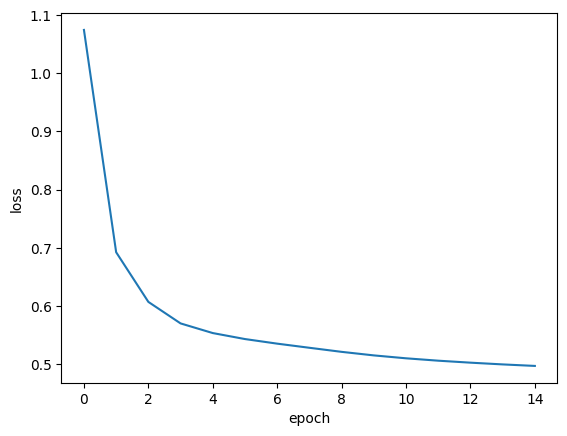

In [145]:
loss = [1.0746,0.6923,0.6069,0.5699,0.5533,0.5430,0.5351,0.5280,0.5210,0.5149,0.5099,0.5058,0.5024,0.4994,0.4968]
epoch = range(15)
plt.plot(epoch,loss)
plt.xlabel('epoch')
plt.ylabel('loss')

#### Model has converged, though it looks like the learning rate could still be reduced slightly to get better learning. We will keep it here for now in the interest of time and efficiency.

## Model Architecture + Hyperparameter Tuning

#### To get the best model possible, I will tweak the architecture and parameters to determine the best model on 15 epochs.
#### Will start with tuning architecture by increasing the number of (conv-conv-maxpool) sequences and trying different activation functions. I will include padding in this model to maintain image size through all of the convolution steps.

In [152]:
model2 = build_model(n=4, padding = 'same')
model2.fit(train_dataset, epochs = 15)

[<keras.layers.convolutional.conv2d.Conv2D object at 0x1c7867520>, <keras.layers.convolutional.conv2d.Conv2D object at 0x1c7859e80>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x1c5d03100>, <keras.layers.convolutional.conv2d.Conv2D object at 0x1c7d60670>, <keras.layers.convolutional.conv2d.Conv2D object at 0x1c7d60970>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x1c7d60eb0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x1c7d60670>, <keras.layers.convolutional.conv2d.Conv2D object at 0x1c7d60970>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x1c7d60eb0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x1c7d60670>, <keras.layers.convolutional.conv2d.Conv2D object at 0x1c7d60970>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x1c7d60eb0>, <keras.layers.reshaping.flatten.Flatten object at 0x1c7d2d3a0>, <keras.layers.core.dense.Dense object at 0x1c7d2d8e0>]
Epoch 1/15
5501/5501 [==============================] - 338s

Text(0, 0.5, 'loss')

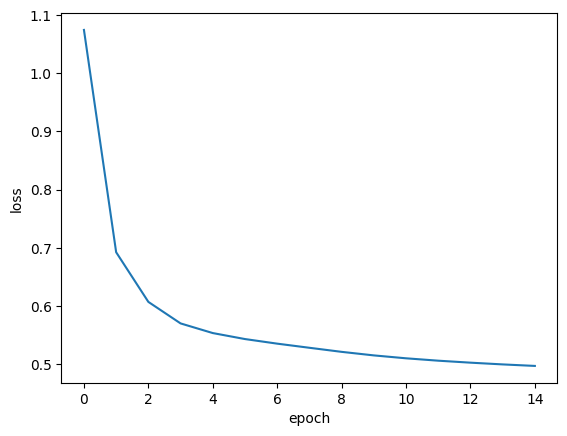

In [153]:
loss = [1.0746,0.6923,0.6069,0.5699,0.5533,0.5430,0.5351,0.5280,0.5210,0.5149,0.5099,0.5058,0.5024,0.4994,0.4968]
epoch = range(15)
plt.plot(epoch,loss)
plt.xlabel('epoch')
plt.ylabel('loss')

#### For hyperparameter tuning, will try the best architecture with changes to filter size and number of filters, and will introduce padding.

In [157]:
model3 = build_model(n_filts = 10, s_filts = 5, n=4, padding = 'same')
model3.fit(train_dataset, epochs = 15)

Epoch 1/15
5501/5501 [==============================] - 920s 167ms/step - loss: 0.5794 - accuracy: 0.6826
Epoch 2/15
5501/5501 [==============================] - 954s 173ms/step - loss: 0.4692 - accuracy: 0.7836
Epoch 3/15
5501/5501 [==============================] - 924s 168ms/step - loss: 0.4577 - accuracy: 0.7900
Epoch 4/15
5501/5501 [==============================] - 922s 168ms/step - loss: 0.4495 - accuracy: 0.7941
Epoch 5/15
5501/5501 [==============================] - 935s 170ms/step - loss: 0.4433 - accuracy: 0.7982
Epoch 6/15
5501/5501 [==============================] - 905s 165ms/step - loss: 0.4385 - accuracy: 0.8012
Epoch 7/15
5501/5501 [==============================] - 880s 160ms/step - loss: 0.4338 - accuracy: 0.8032
Epoch 8/15
5501/5501 [==============================] - 887s 161ms/step - loss: 0.4300 - accuracy: 0.8055
Epoch 9/15
5501/5501 [==============================] - 872s 159ms/step - loss: 0.4261 - accuracy: 0.8084
Epoch 10/15
5501/5501 [=======================

Text(0, 0.5, 'loss')

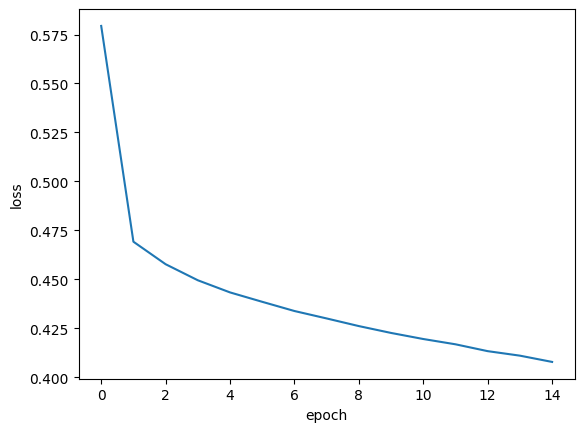

In [167]:
loss = [0.5794,0.4692,0.4577,0.4495,0.4433,0.4385,0.4338,0.4300,0.4261,0.4226,0.4195,0.4168,0.4133,0.4110,0.4078]
epoch = range(15)
plt.plot(epoch,loss)
plt.xlabel('epoch')
plt.ylabel('loss')

#### The accuracy improved, but not by much. Next try a model with more filters but with the smaller filter size

In [159]:
model4 = build_model(n_filts = 12, s_filts = 3, n=4, padding = 'same')
model4.fit(train_dataset, epochs = 15)

Epoch 1/15


2025-02-18 07:59:04.902560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [176020]
	 [[{{node Placeholder/_0}}]]
2025-02-18 07:59:04.904152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [176020]
	 [[{{node Placeholder/_4}}]]


5501/5501 [==============================] - 1141s 207ms/step - loss: 0.5738 - accuracy: 0.7033
Epoch 2/15
5501/5501 [==============================] - 894s 162ms/step - loss: 0.5014 - accuracy: 0.7650
Epoch 3/15
5501/5501 [==============================] - 1513s 275ms/step - loss: 0.4814 - accuracy: 0.7773
Epoch 4/15
5501/5501 [==============================] - 1443s 262ms/step - loss: 0.4697 - accuracy: 0.7834
Epoch 5/15
5501/5501 [==============================] - 1394s 253ms/step - loss: 0.4612 - accuracy: 0.7880
Epoch 6/15
5501/5501 [==============================] - 1410s 256ms/step - loss: 0.4545 - accuracy: 0.7917
Epoch 7/15
5501/5501 [==============================] - 1452s 264ms/step - loss: 0.4487 - accuracy: 0.7949
Epoch 8/15
5501/5501 [==============================] - 1486s 270ms/step - loss: 0.4438 - accuracy: 0.7969
Epoch 9/15
5501/5501 [==============================] - 1479s 269ms/step - loss: 0.4395 - accuracy: 0.7992
Epoch 10/15
5501/5501 [==========================

Text(0, 0.5, 'loss')

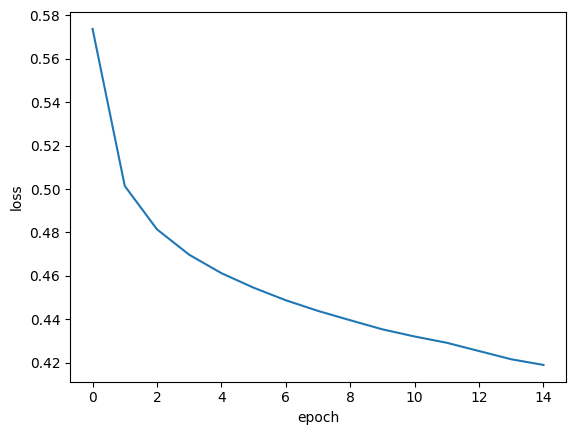

In [166]:
loss = [0.5738,0.5014,0.4814,0.4697,0.4612,0.4545,0.4487,0.4438,0.4395,0.4353,0.4320,0.4291,0.4253,0.4215,0.4189]
epoch = range(15)
plt.plot(epoch,loss)
plt.xlabel('epoch')
plt.ylabel('loss')

In [170]:
model5 = build_model(n_filts = 10, s_filts = 5, n=4, padding = 'same', learning_rate = 0.000005)
model5.fit(train_dataset, epochs = 25)

Epoch 1/25
5501/5501 [==============================] - 3033s 551ms/step - loss: 0.9041 - accuracy: 0.6848
Epoch 2/25
5501/5501 [==============================] - 2937s 534ms/step - loss: 0.5315 - accuracy: 0.7521
Epoch 3/25
5501/5501 [==============================] - 2746s 499ms/step - loss: 0.5040 - accuracy: 0.7688
Epoch 4/25
5501/5501 [==============================] - 2691s 489ms/step - loss: 0.4905 - accuracy: 0.7750
Epoch 5/25
5501/5501 [==============================] - 2699s 491ms/step - loss: 0.4805 - accuracy: 0.7792
Epoch 6/25
5501/5501 [==============================] - 2723s 495ms/step - loss: 0.4728 - accuracy: 0.7831
Epoch 7/25
5501/5501 [==============================] - 2637s 479ms/step - loss: 0.4674 - accuracy: 0.7852
Epoch 8/25
5501/5501 [==============================] - 2630s 478ms/step - loss: 0.4625 - accuracy: 0.7872
Epoch 9/25
5501/5501 [==============================] - 2155s 392ms/step - loss: 0.4572 - accuracy: 0.7908
Epoch 10/25
5501/5501 [==============

#### Try one more with higher n

In [174]:
model5 = build_model(n_filts = 12, s_filts = 3, n=3, padding = 'same')
model5.fit(train_dataset, epochs = 25)

Epoch 1/25
5501/5501 [==============================] - 1601s 291ms/step - loss: 0.7306 - accuracy: 0.6459
Epoch 2/25
5501/5501 [==============================] - 1781s 324ms/step - loss: 0.5134 - accuracy: 0.7600
Epoch 3/25
5501/5501 [==============================] - 1829s 332ms/step - loss: 0.4733 - accuracy: 0.7829
Epoch 4/25
5501/5501 [==============================] - 2125s 386ms/step - loss: 0.4586 - accuracy: 0.7909
Epoch 5/25
5501/5501 [==============================] - 2314s 421ms/step - loss: 0.4493 - accuracy: 0.7958
Epoch 6/25
5501/5501 [==============================] - 2402s 437ms/step - loss: 0.4427 - accuracy: 0.7990
Epoch 7/25
5501/5501 [==============================] - 2341s 425ms/step - loss: 0.4377 - accuracy: 0.8014
Epoch 8/25
5501/5501 [==============================] - 2310s 420ms/step - loss: 0.4338 - accuracy: 0.8030
Epoch 9/25
5501/5501 [==============================] - 2172s 395ms/step - loss: 0.4302 - accuracy: 0.8050
Epoch 10/25
5501/5501 [==============

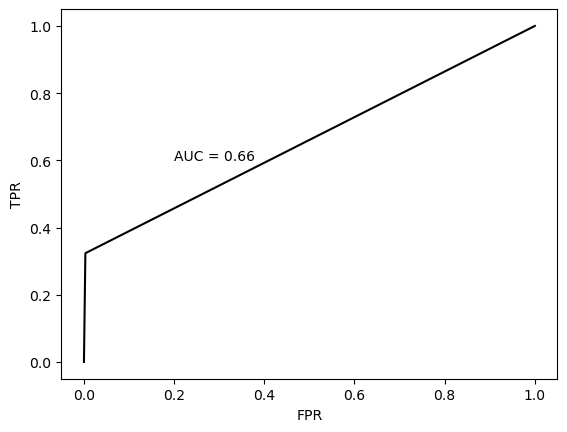

In [122]:
fpr, tpr, th = roc_curve(test_labels, ypred)
auc = roc_auc_score(test_labels, ypred)
auc = round(auc,3)
plt.plot(fpr,tpr, 'k-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.text(0.2,0.6, f'AUC = {auc}')
plt.show()

#### The ROC curve is not the best metric for this dataset because there are so few positives. Out of 350 observations, only 34 are true positives. This creates bias and skews the ROC curve. It is still a good visualization to further enforce the idea that the model is better at recognizing negative values than positive ones.

## Discussion and Conclusions

#### The final model predicted binding of small molecule drugs with an accuracy of 0.93. The confusion matrix showed that the model is better at predicting true negatives than true positives. Additionally, as expected, the SVM algorithm worked the best for modeling this sparse dataset and was able to handle all features. 

#### One key takeaway from this project was that parameter tuning for the SVC model didn't make much difference in the prediction power of the model. Both parameters tested in the tuning process, C and loss, did not have much impact on model performance. It's possible that with better feature selection the parameter tuning could have made a bigger difference. This could also be due to the intrinsic bias of the model- with such a sparse dataset, it's possible that the power of changing C and loss did not have as strong of an impact as it would with a less sparse dataset.

#### There are many ways to have made this model better. Due to constraints in time and computing power, the feature selection was not able to be tuned properly for the final model and all features were used. It's possible that proper feature selection could have improved the final model. Additionally, the final model did not predict positive values as well as negative values. It's possible that with better parameter tuning or other changes to reduce bias that this could have been improved.